Imported Libaries

In [23]:
import pandas as pd
import chardet
import os
from scipy.stats import zscore
pd.options.mode.chained_assignment = None
from sqlalchemy import create_engine, text, inspect
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from IPython.display import display as original_display
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
import numpy as np
import seaborn as sns
import inspect
import re
import string
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

Standard Functions

In [24]:
#Function to clean labels in any plot functions
def clean_label(label):
    return label.replace('_', ' ').title()
 
#Function for getting the name of a Dataframe
def get_var_name(var):
    for name, value in globals().items():
        if value is var:
            return name
 
#Function to validate the data in a Dataframe
def validate_data(df, show_counts=True):
    df_name = get_var_name(df)
    print(f'#########################################################################################################################################################################################\nDataFrame: {df_name}')
    #snapshot the dataset
    display(df)
    #check for unique values
    unique_counts = pd.DataFrame(df.nunique())
    unique_counts = unique_counts.reset_index().rename(columns={0:'No. of Unique Values', 'index':'Field Name'})
    print("Unique values per field:")
    pd.set_option('display.max_rows', None)
    display(unique_counts)
    pd.reset_option('display.max_rows')
    #checking for duplicates
    duplicate_count = df.duplicated().sum()
    print("\nNumber of duplicate rows:")
    print(duplicate_count,'\n')
    info = df.info(show_counts=show_counts)
    display(info)
    #summary stats
    print("\nSummary statistics:")
    display(df.describe())
    print('End of data validation\n#########################################################################################################################################################################################\n')
 
#Function to provide list for data sources as a dataframe when conducting analysis
def header_list(df):
    df_list_ = df.copy()
    df_list = df_list_.columns.tolist()
    df_list = pd.DataFrame(df_list)
    new_header = df_list.iloc[0]  # Get the first row for the header
    df_list = df_list[1:]  # Take the data less the header row
    df_list.columns = new_header  # Set the header row as the df header
    df_list.reset_index(drop=True, inplace=True)  # Reset index
   
    return df_list
 
def query_data(schema, data):
    # Define the SQL query
    query = f'SELECT * FROM [{schema}].[{data}]'
 
    # Load data into DataFrame
    df = pd.read_sql(query, engine)
 
    print(f'Successfully imported {data}')
    # Display the DataFrame
    return df

def display(df):
    # Attempt to get the name of the DataFrame from the caller's local variables
    frame = inspect.currentframe().f_back
    # Attempt to find the variable name corresponding to the DataFrame
    name = "Unnamed DataFrame"
    for var_name, var_value in frame.f_locals.items():
        if var_value is df:
            name = var_name
            break
 
    # If the name is not in the list to be excluded, print it
    if name not in {'df', 'Unnamed DataFrame', 'unique_counts'}:
        print(f"DataFrame: {name}")
    # Always display the DataFrame regardless of the name
    original_display(df)

def unique_values(df, display_df=True):
    # Extract unique values for each field and store them in a dictionary
    unique_values = {col: df[col].unique() for col in df.columns}
    # Find the maximum number of unique values
    max_length = max(len(values) for values in unique_values.values())
    # Create a dictionary for the new DataFrame with padded None values
    unique_df_data = {}
    for col, values in unique_values.items():
        unique_df_data[col] = list(values) + [None] * (max_length - len(values))
    # Create the new DataFrame
    unique_df = pd.DataFrame(unique_df_data)
    if display_df == True:
        # Set display options to show all rows and display the DataFrame
        pd.set_option('display.max_rows', None)
        display(unique_df.head(100))
        # Reset display options back to default
        pd.reset_option('display.max_rows')

def export_to_csv(df):
    df_name = get_var_name(df)
    # Specify the directory and filename
    directory = r"C:\Users\jf79\OneDrive - Office Shared Service\Documents\H&F Analysis\Python CSV Repositry"
    file_path = f'{directory}\\{df_name}.csv'
    # Export the DataFrame to the specified directory
    df.to_csv(file_path, index=False)
    print(f'Successfully exported {df_name} to CSV')

Specific Functions for this Script

In [43]:
def detect_anomalies(df, category, std=3, day_night=False,agg=False):
    if agg:
        agg = f'{agg}'
    else:
        agg='sum'
    categories = [
        'count_date',f'{category}_{agg}',
        'zscore','is_anomaly?'
    ]
    if day_night:
        categories = [
            'count_date',f'{category}_{agg}',
            'zscore','is_anomaly?','day_night'
        ]

    anomalies = df.copy()
    anomalies['zscore'] = zscore(anomalies[f'{category}_{agg}'])
    anomalies['is_anomaly?'] = (anomalies['zscore'] < -std) | (anomalies['zscore'] > std)

    anomalies = anomalies[categories]
    anomalies['year'] = anomalies['count_date'].dt.year
    anomalies['moving_average'] = anomalies[f'{category}_{agg}'].rolling(window=7).mean()
    anomalies['corrected_value'] = np.where(
        anomalies['is_anomaly?'],
        anomalies['moving_average'],
        anomalies[f'{category}_{agg}']
    )
    anomalies['corrected_ma_monthly'] = anomalies['corrected_value'].rolling(window=30).mean()
    anomalies['corrected_ma_weekly'] = anomalies['corrected_value'].rolling(window=7).mean()

    return anomalies


def agg_footfall_data(df,day_night=False,agg=False,include_residents=False,residents_only=False,workers_only=False,visitors_only=False):  
    merge_list = ['count_date']
    new_categories = [
        'count_date','corrected_ma_monthly',
        'corrected_ma_weekly','corrected_value'
    ]
    if day_night:
        merge_list = merge_list + ['day_night']
        new_categories = new_categories + ['day_night']
    if agg:
        agg = f'{agg}'
    else:
        agg='sum'
    agg_data = df.groupby(merge_list).agg(
        residents_sum = ('resident','sum'),
        workers_sum = ('worker','sum'),
        visitors_sum = ('visitor','sum'),
        residents_mean = ('resident','mean'),
        workers_mean = ('worker','mean'),
        visitors_mean = ('visitor','mean'),
        loyalty = ('loyalty_percentage','mean'),
        dwell_time = ('dwell_time','mean')
    )

    agg_data = agg_data.reset_index()
    agg_data = agg_data.sort_values(
        ['count_date'],
        ascending=False
    )

    resident_z = detect_anomalies(agg_data,'residents',2.6,day_night=day_night,agg=agg)
    worker_z = detect_anomalies(agg_data,'workers',2.6,day_night=day_night,agg=agg)
    visitor_z = detect_anomalies(agg_data,'visitors',2.6,day_night=day_night,agg=agg)

    resident_merge = resident_z[new_categories]
    worker_merge = worker_z[new_categories]
    new_categories = new_categories + ['year']
    visitor_merge = visitor_z[new_categories]
    
    merge = pd.merge(
        resident_merge, worker_merge,
        how='left', on=merge_list,
        suffixes=['_res','_work']
    ).merge(
        visitor_merge,
        how='left', on=merge_list
    )

    if include_residents:
        merge['corrected_value_total'] = merge['corrected_value_res'] + merge['corrected_value_work'] + merge['corrected_value']
    elif residents_only:
        merge['corrected_value_total'] = merge['corrected_value_res']
    elif workers_only:
        merge['corrected_value_total'] = merge['corrected_value_work']
    elif visitors_only:
        merge['corrected_value_total'] = merge['corrected_value']
    else:
        merge['corrected_value_total'] = merge['corrected_value_work'] + merge['corrected_value']
    
    merge['corrected_ma_monthly_total'] = merge['corrected_value_total'].rolling(window=30).mean()
    merge['corrected_ma_weekly_total'] = merge['corrected_value_total'].rolling(window=7).mean()

    return merge

def apply_features(df,date='count_date'):
    df['day_name'] = df[f'{date}'].dt.dayofweek

    dictionary = {
        '0':'Monday',
        '1':'Tuesday',
        '2':'Wednesday',
        '3':'Thursday',
        '4':'Friday',
        '5':'Saturday',
        '6':'Sunday'
    }
    df['day_name'] = df['day_name'].astype(str)
    df['day_name'] = df['day_name'].map(dictionary)

    return df

def apply_daynight_features(df):
    dictionary = {
        '00-03':'6pm-6am',
        '03-06':'6pm-6am',
        '06-09':'6am-6pm',
        '09-12':'6am-6pm',
        '12-15':'6am-6pm',
        '15-18':'6am-6pm',
        '18-21':'6pm-6am',
        '21-24':'6pm-6am'
    }

    df['day_night'] = df['time_indicator'].map(dictionary)

    return df

def transform_to_daynight(df):
    transform = df.copy()
    transform = transform.pivot_table(
        index = ['count_date','year','day_name'],
        columns='day_night',
        values='corrected_value_total'
    ).reset_index()
    
    return transform

def calulcaute_QoQ_values(df):
    df = df.set_index('count_date')
    df = df[['corrected_value_total']]
    quarterly_df = df.resample('Q').mean()
    # Calculate Quarter-over-Quarter (QoQ) percentage change
    quarterly_df['QoQ_change'] = quarterly_df['corrected_value_total'].pct_change() * 100
    # Calculate Year-over-Year (YoY) percentage change, looking back 4 quarters
    quarterly_df['YoY_change'] = quarterly_df['corrected_value_total'].pct_change(periods=4) * 100
    quarterly_df = quarterly_df.round(2)
    display(quarterly_df)
    return quarterly_df


Plot Functions Specific to this Script

In [26]:
def plot_footfall(df, df2=None, year=False, category=False, dual_axis=False):
    tf = df.copy()
    if df2 is not None:
        tf2 = df2.copy()
    title = f'Comparison of Normalised Footfall (Monthly MA)'
    if year:
        tf = tf[tf['year'] == year]
        if df2 is not None:
            tf2 = tf2[tf2['year'] == year]
        title = f'{title} ({year})'
    
    if category == 'normalized':
        tf['corrected_normalized'] = tf['corrected_ma_monthly_total']/tf['corrected_ma_monthly_total'].max()
        if df2 is not None:
            tf2['corrected_normalized'] = tf2['corrected_ma_monthly_total']/tf2['corrected_ma_monthly_total'].max()

    if dual_axis:
        fig, ax1 = plt.subplots(figsize=(10, 7))
        ax1.plot(
            tf['count_date'],
            tf[f'corrected_{category}'],
            label='Footfall (London)',
            color='red'
        )
        ax1.set_xlabel('Date', fontsize=14)
        ax1.set_ylabel('Footfall Count (London)', color='blue', fontsize=14)
        ax1.tick_params(axis='y', color='blue', labelsize=12)
        ax1.legend(loc='upper left')

        if df2 is not None:
            ax2 = ax1.twinx()  # Create a secondary y-axis
            ax2.plot(
                tf2['count_date'],
                tf2[f'corrected_{category}'],
                label='Footfall (H&F)',
                color='blue'
            )
            ax2.set_ylabel('Footfall Count (H&F)', color='red')
            ax2.tick_params(axis='y', labelcolor='red')
            ax2.legend(loc='upper right')

        plt.title(f'{title}')
        plt.show()

    if category and dual_axis == False:
        plt.figure(figsize=(12,7))

        plt.plot(
            tf['count_date'],
            tf[f'corrected_{category}'],
            label = 'Normalised Footfall (London)',
            color = 'red'
        )

        if df2 is not None:
            plt.plot(
            tf2['count_date'],
            tf2[f'corrected_{category}'],
            label = 'Normalised Footfall (H&F)',
            color = 'blue'
            )
        
        seasons = {
            'Winter':('01-01','03-20','lightblue'),
            'Spring':('03-21','06-20','lightgreen'),
            'Summer':('06-21','09-22','gold'),
            'Autumn':('09-23','12-21','orange'),
            'Christmas':('12-22','12-31','red'),
        }
        if year:
            plot_years = year
            for season, (start_md, end_md, colour) in seasons.items():
                start = f'{year}-{start_md}'
                end = f'{year}-{end_md}'
                plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color=colour, alpha=0.25, label=season)
        else:
            plot_years = range(2022,2025)         
            for year in plot_years:
                for season, (start_md, end_md, colour) in seasons.items():
                    start = f'{year}-{start_md}'
                    end = f'{year}-{end_md}'
                    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color=colour, alpha=0.25, label=season)
        
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Normalised Footfall', fontsize=12)
        plt.title(f'{title}', fontsize=16)
        plt.legend(
            by_label.values(),
            by_label.keys(),
            fontsize=9
        )
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.xlim(
            right = tf['count_date'].max(),
            left = tf['count_date'].min()
        )
        plt.show()

    else:
        print('## Please specify a category ##')

def plot_daily_footfall(df, df2=None, year=False, day_night=False):
    title = f'Comparison of Daytime and Nightime Footfall'
    merge_list = ['day_name']
    tf = df.copy()
    if df2 is not None:
        tf2 = df2.copy()
    if year:
        tf = tf[tf['year'] == year]
        if df2 is not None:
            tf2 = tf2[tf2['year'] == year]
        title = f'{title} ({year})'
    
    if day_night:
        tf = transform_to_daynight(tf)
        if df2 is not None:
            tf2 = transform_to_daynight(tf2)

    # Aggregate data for both datasets and merge them
    aggregated_data = tf.groupby(merge_list).agg(
        Nighttime_mean = ('6pm-6am','mean'),
        Daytime_mean = ('6am-6pm','mean'),
    ).reset_index()
    
    if df2 is not None:
        aggregated_data = pd.merge(
            aggregated_data,
            tf2.groupby(merge_list).agg(
            Nighttime_mean = ('6pm-6am','mean'),
            Daytime_mean = ('6am-6pm','mean'),
            ).reset_index(),
            how='left', on=merge_list,
            suffixes=['_lon', '_lbhf']
        )

    dictionary = {
        'Monday':'0',
        'Tuesday':'1',
        'Wednesday':'2',
        'Thursday':'3',
        'Friday':'4',
        'Saturday':'5',
        'Sunday':'6'
    }
    aggregated_data['day_order'] = aggregated_data['day_name'].map(dictionary)
    aggregated_data = aggregated_data.set_index('day_order').sort_index()
    display(aggregated_data)
    
    # Extract categories and values for plotting
    categories = aggregated_data['day_name'].unique()

    if df2 is not None:
        night1 = aggregated_data['Nighttime_mean_lon']
        day1 = aggregated_data['Daytime_mean_lon']
        night2 = aggregated_data['Nighttime_mean_lbhf']
        day2 = aggregated_data['Daytime_mean_lbhf']
    else:
        night1 = aggregated_data['Nighttime_mean']
        day1 = aggregated_data['Daytime_mean']

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(len(categories))

    if df2 is not None:
        # Plot daytime and nighttime footfall data
        ax.bar(index, day1, bar_width, label='Daytime Footfall (LDN)', color='skyblue')
        ax.bar([i + bar_width for i in index], night1, bar_width, label='Nighttime Footfall (LDN)', color='blue')
        ax.bar(index, day2, bar_width, label='Daytime Footfall (LBHF)', color='skyblue')
        ax.bar([i + bar_width for i in index], night2, bar_width, label='Nighttime Footfall (LBHF)', color='blue')
    else:
        # Plot daytime and nighttime footfall data
        ax.bar(index, day1, bar_width, label='Daytime Footfall (LBHF)', color='skyblue')
        ax.bar([i + bar_width for i in index], night1, bar_width, label='Nighttime Footfall (LBHF)', color='blue')

    # Set axis labels and title
    ax.set_xlabel("Days of the Week", fontsize=14)
    ax.set_ylabel("Total Footfall", fontsize=14)
    ax.set_title("Comparison of Daytime and Nighttime Footfall (2024)", fontsize=16)
    ax.set_xticks([i + bar_width / 2 for i in index])
    ax.set_xticklabels(aggregated_data['day_name'])
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x/1_000)}K'))
    ax.tick_params(axis='both', which='major', labelsize=12)
    if df2 is not None:
        ax.set_ylim([min(night2)-(min(night2)*0.1), max(day1) * 1.1])
    else:
        ax.set_ylim([min(night1)-(min(night1)*0.1), max(day1) * 1.1])

    ax.legend(fontsize=14)
    plt.tight_layout()
    plt.show()

Database and CWD setup and connection

In [27]:
# Database credentials
db_host = 'LBHHLWSQL0001.lbhf.gov.uk'
db_port = '1433'
db_name = 'IA_ODS'

# Create the connection string for SQL Server using pyodbc with Windows Authentication
connection_string = f'mssql+pyodbc://@{db_host}:{db_port}/{db_name}?driver=ODBC+Driver+17+for+SQL+Server&Trusted_Connection=yes'

# Create the database engine
engine = create_engine(connection_string)

files = os.listdir(os.getcwd())
print("Files in: %s" % (files))

Files in: ['BT Hex ID to Borough Lookup Table.csv', 'hex_3hourly_counts_2022.csv', 'hex_3hourly_counts_2023.csv', 'hex_3hourly_counts_2024.csv', 'hex_3hourly_counts_2025.csv']


In [28]:
cwd = 'C:/Users/jf79/OneDrive - Office Shared Service/Documents/H&F Analysis/Footfall and Spend Analysis/Footfall Data/Hex Based/Footfall Counts'
os.chdir(cwd)
directory = os.getcwd()
files = os.listdir(os.getcwd())
print(f"Your Current Directory is: {directory}")
print("Files in: %s" % (files))

Your Current Directory is: C:\Users\jf79\OneDrive - Office Shared Service\Documents\H&F Analysis\Footfall and Spend Analysis\Footfall Data\Hex Based\Footfall Counts
Files in: ['BT Hex ID to Borough Lookup Table.csv', 'hex_3hourly_counts_2022.csv', 'hex_3hourly_counts_2023.csv', 'hex_3hourly_counts_2024.csv', 'hex_3hourly_counts_2025.csv']


In [29]:
footfall_2022 = pd.read_csv('hex_3hourly_counts_2022.csv')
footfall_2023 = pd.read_csv('hex_3hourly_counts_2023.csv')
footfall_2024 = pd.read_csv('hex_3hourly_counts_2024.csv')
footfall_2025 = pd.read_csv('hex_3hourly_counts_2025.csv')
hex_to_borough = pd.read_csv('BT Hex ID to Borough Lookup Table.csv')

In [30]:
weather_data = pd.read_csv('C:/Users/jf79/OneDrive - Office Shared Service/Documents/H&F Analysis/Footfall and Spend Analysis/Miscellaneous Data/Heathrow Historic Weather Data.csv')

In [31]:
footfall_data_2022 = footfall_2022.copy()
footfall_data_2023 = footfall_2023.copy()
footfall_data_2024 = footfall_2024.copy()
footfall_data_2025 = footfall_2025.copy()
hex_to_borough_data = hex_to_borough.copy()

footfall_data = pd.concat([footfall_data_2022,footfall_data_2023,footfall_data_2024,footfall_data_2025])

footfall_data = pd.merge(footfall_data,hex_to_borough_data, left_on='hex_id', right_on='Hex_ID', how='left')

In [32]:
lon_footfall_data = footfall_data.copy()

lon_footfall_data = lon_footfall_data.drop(
    columns = [
        'Hex_ID','GSS_CODE','day'
    ]
)

columns_to_convert = [
    'resident','visitor','worker'
]
lon_footfall_data.loc[:, columns_to_convert] = lon_footfall_data[columns_to_convert].applymap(lambda x: np.nan if x < 0 else x)
lon_footfall_data[columns_to_convert] = lon_footfall_data[columns_to_convert].fillna(0)
lon_footfall_data[columns_to_convert] = lon_footfall_data[columns_to_convert].astype('uint16')

lon_footfall_data['time_indicator'] = lon_footfall_data['time_indicator'].str.strip("'")
lon_footfall_data['count_date'] = pd.to_datetime(lon_footfall_data['count_date'])
lon_footfall_data['year'] = lon_footfall_data['count_date'].dt.year
lon_footfall_data['month'] = lon_footfall_data['count_date'].dt.month
lon_footfall_data['DoY'] = lon_footfall_data['count_date'].dt.day_of_year

lon_footfall_data['time_indicator'] = lon_footfall_data['time_indicator'].astype('category')

lon_footfall_data = lon_footfall_data.dropna(
    subset=[
        'dwell_time','resident','visitor','worker'
    ],
    how='all'
)

lon_footfall_data.sort_values(by=['count_date','time_indicator','hex_id'], inplace=True)
lon_footfall_data = apply_daynight_features(lon_footfall_data)

In [33]:
dn_lon_footfall_data = lon_footfall_data.copy()
dn_lbhf_footfall_data = lon_footfall_data.copy()
dn_lbhf_footfall_data = dn_lbhf_footfall_data[dn_lbhf_footfall_data['borough_name'] == 'H&F']
print('Data copied')
dn_lon_footfall_data = agg_footfall_data(dn_lon_footfall_data,day_night=True)
dn_lbhf_footfall_data = agg_footfall_data(dn_lbhf_footfall_data,day_night=True)
dn_lon_footfall_data = apply_features(dn_lon_footfall_data)
dn_lbhf_footfall_data = apply_features(dn_lbhf_footfall_data)

Data copied


In [34]:
agg_lon_footfall_data = lon_footfall_data.copy()
agg_lbhf_footfall_data = lon_footfall_data.copy()
agg_lbhf_footfall_data = agg_lbhf_footfall_data[agg_lbhf_footfall_data['borough_name'] == 'H&F']
print('Data copied')
agg_lon_footfall_data = agg_footfall_data(agg_lon_footfall_data,include_residents=True)
agg_lbhf_footfall_data = agg_footfall_data(agg_lbhf_footfall_data,include_residents=True)
agg_lon_footfall_data = apply_features(agg_lon_footfall_data)
agg_lbhf_footfall_data = apply_features(agg_lbhf_footfall_data)

Data copied


In [35]:
no_res_lon_footfall_data = lon_footfall_data.copy()
no_res_lbhf_footfall_data = lon_footfall_data.copy()
no_res_lbhf_footfall_data = no_res_lbhf_footfall_data[no_res_lbhf_footfall_data['borough_name'] == 'H&F']
print('Data copied')
no_res_lon_footfall_data = agg_footfall_data(no_res_lon_footfall_data,include_residents=False)
no_res_lbhf_footfall_data = agg_footfall_data(no_res_lbhf_footfall_data,include_residents=False)
no_res_lon_footfall_data = apply_features(no_res_lon_footfall_data)
no_res_lbhf_footfall_data = apply_features(no_res_lbhf_footfall_data)

Data copied


In [36]:
vis_lon_footfall_data = lon_footfall_data.copy()
vis_lbhf_footfall_data = lon_footfall_data.copy()
vis_lbhf_footfall_data = vis_lbhf_footfall_data[vis_lbhf_footfall_data['borough_name'] == 'H&F']
print('Data copied')
vis_lon_footfall_data = agg_footfall_data(vis_lon_footfall_data,visitors_only=True)
vis_lbhf_footfall_data = agg_footfall_data(vis_lbhf_footfall_data,visitors_only=True)
vis_lon_footfall_data = apply_features(vis_lon_footfall_data)
vis_lbhf_footfall_data = apply_features(vis_lbhf_footfall_data)

Data copied


In [37]:
work_lon_footfall_data = lon_footfall_data.copy()
work_lbhf_footfall_data = lon_footfall_data.copy()
work_lbhf_footfall_data = work_lbhf_footfall_data[work_lbhf_footfall_data['borough_name'] == 'H&F']
print('Data copied')
work_lon_footfall_data = agg_footfall_data(work_lon_footfall_data,workers_only=True)
work_lbhf_footfall_data = agg_footfall_data(work_lbhf_footfall_data,workers_only=True)
work_lon_footfall_data = apply_features(work_lon_footfall_data)
work_lbhf_footfall_data = apply_features(work_lbhf_footfall_data)

Data copied


In [38]:
res_lon_footfall_data = lon_footfall_data.copy()
res_lbhf_footfall_data = lon_footfall_data.copy()
res_lbhf_footfall_data = res_lbhf_footfall_data[res_lbhf_footfall_data['borough_name'] == 'H&F']
print('Data copied')
res_lon_footfall_data = agg_footfall_data(res_lon_footfall_data,residents_only=True)
res_lbhf_footfall_data = agg_footfall_data(res_lbhf_footfall_data,residents_only=True)
res_lon_footfall_data = apply_features(res_lon_footfall_data)
res_lbhf_footfall_data = apply_features(res_lbhf_footfall_data)

Data copied


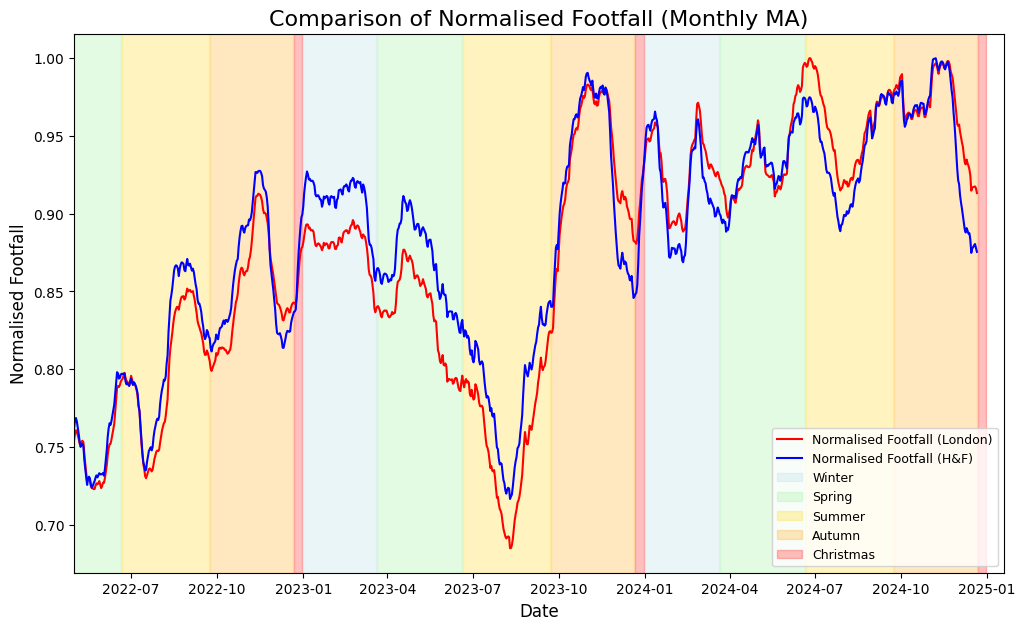

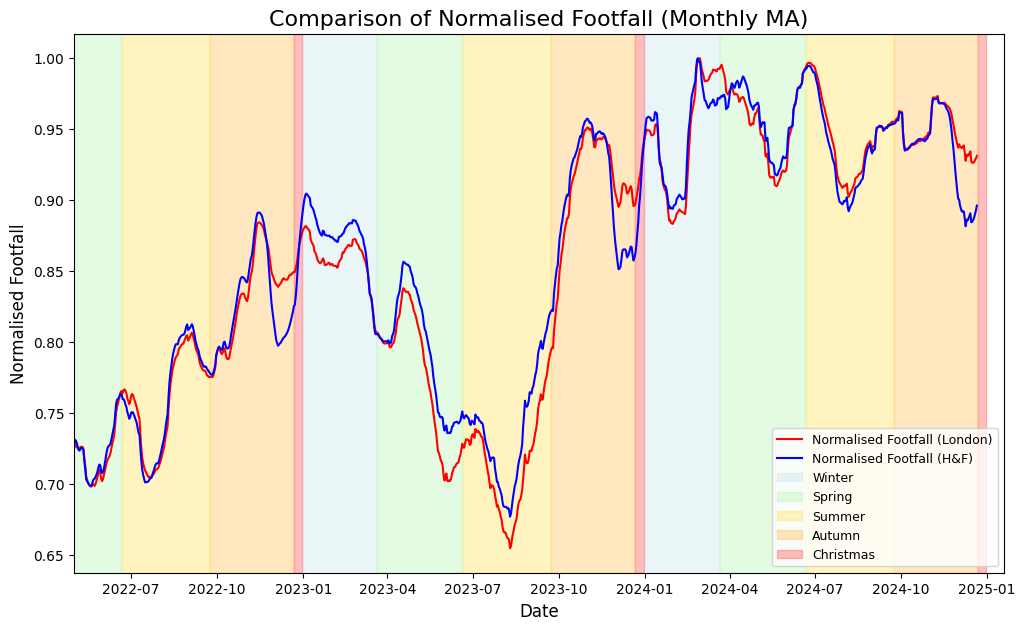

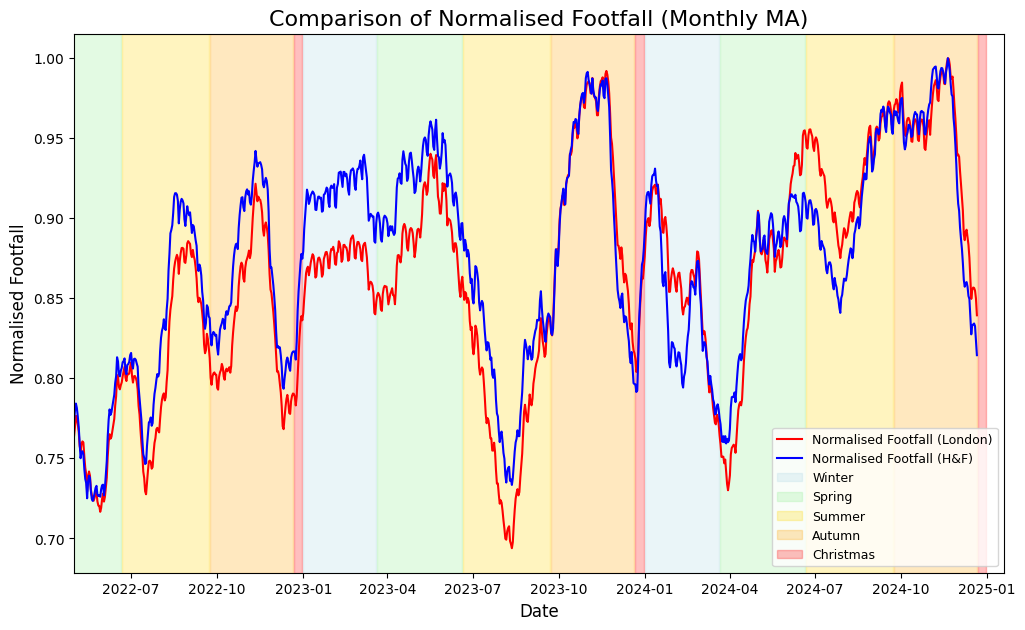

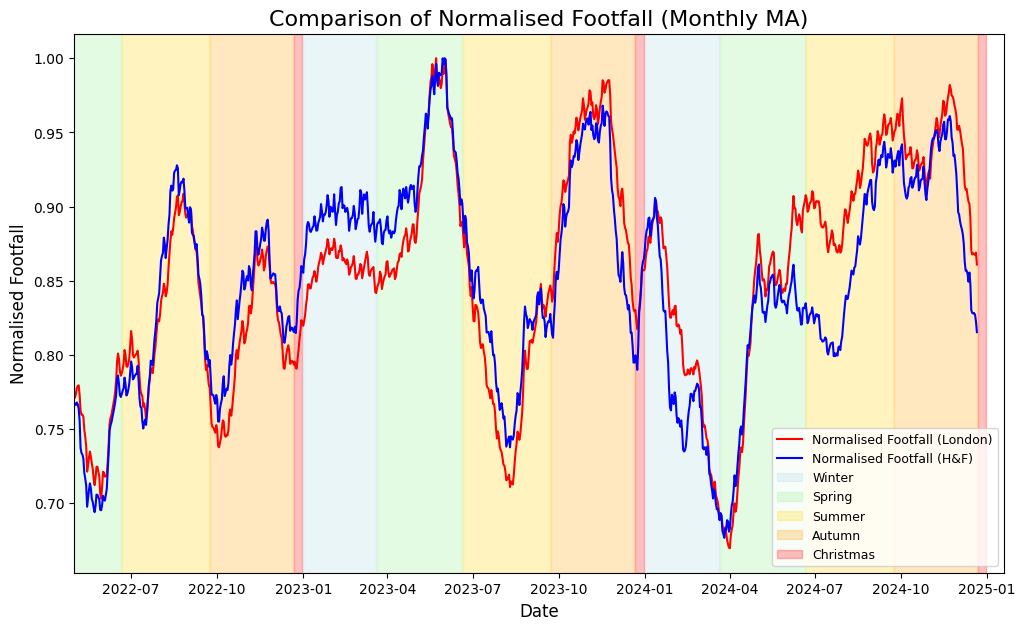

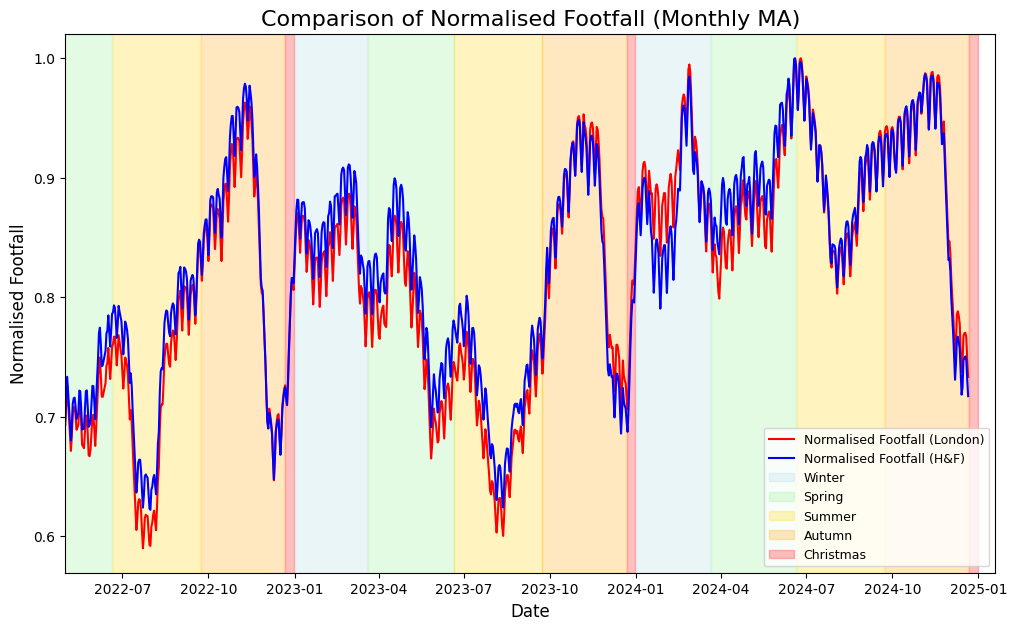

In [39]:
plot_footfall(agg_lon_footfall_data, df2=agg_lbhf_footfall_data, category='normalized')
plot_footfall(res_lon_footfall_data, df2=res_lbhf_footfall_data, category='normalized')
plot_footfall(no_res_lon_footfall_data, df2=no_res_lbhf_footfall_data, category='normalized')
plot_footfall(vis_lon_footfall_data, df2=vis_lbhf_footfall_data, category='normalized')
plot_footfall(work_lon_footfall_data, df2=work_lbhf_footfall_data, category='normalized')

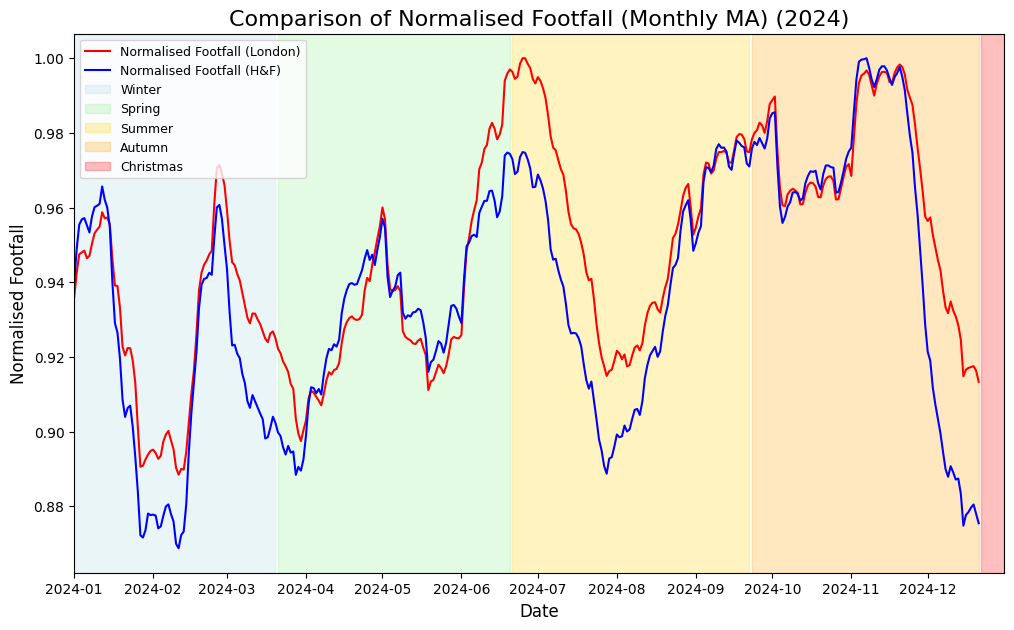

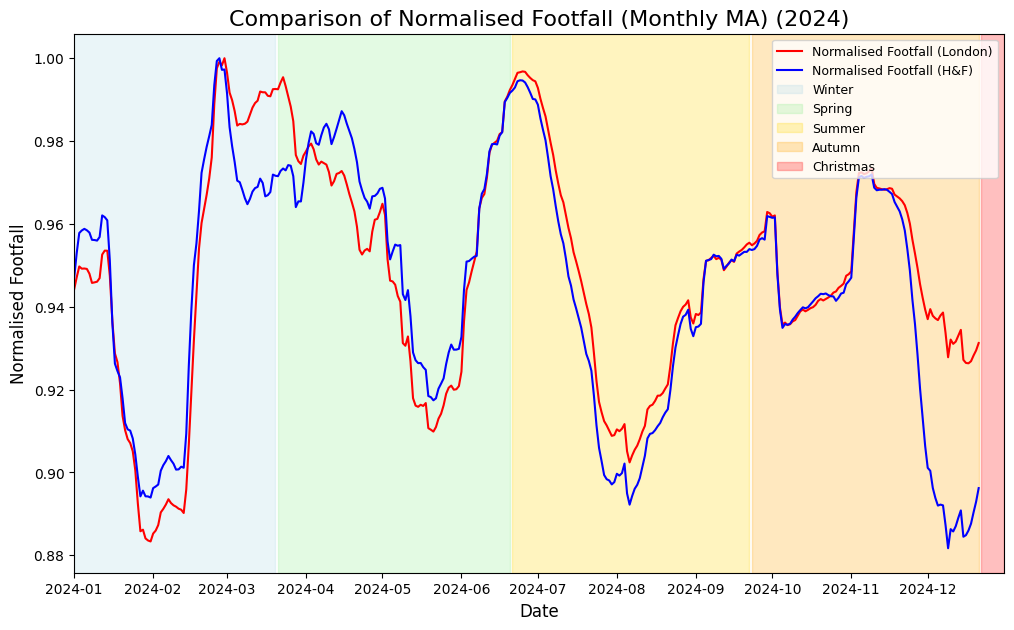

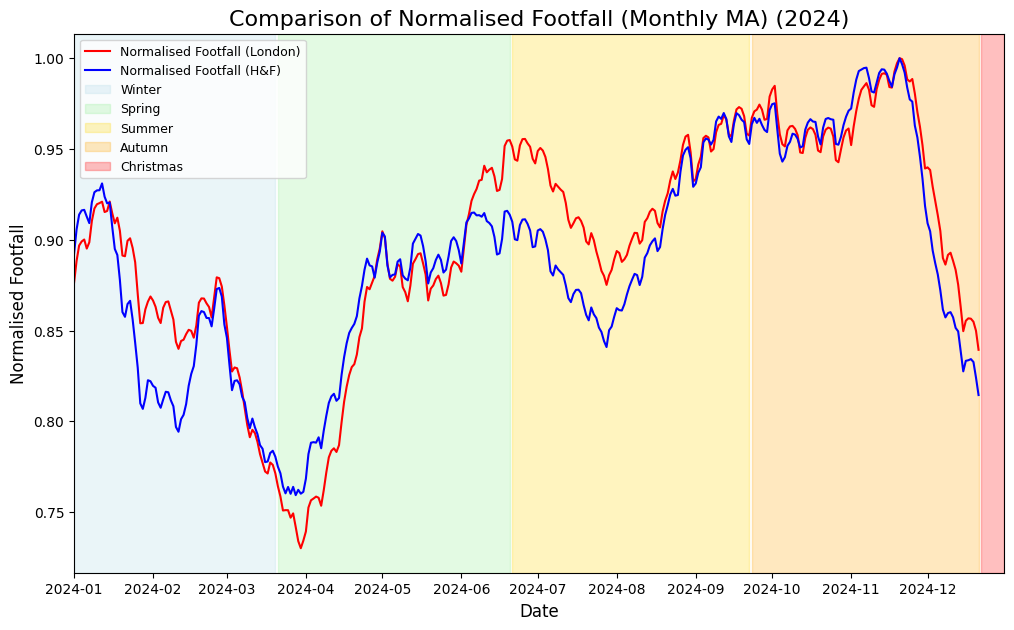

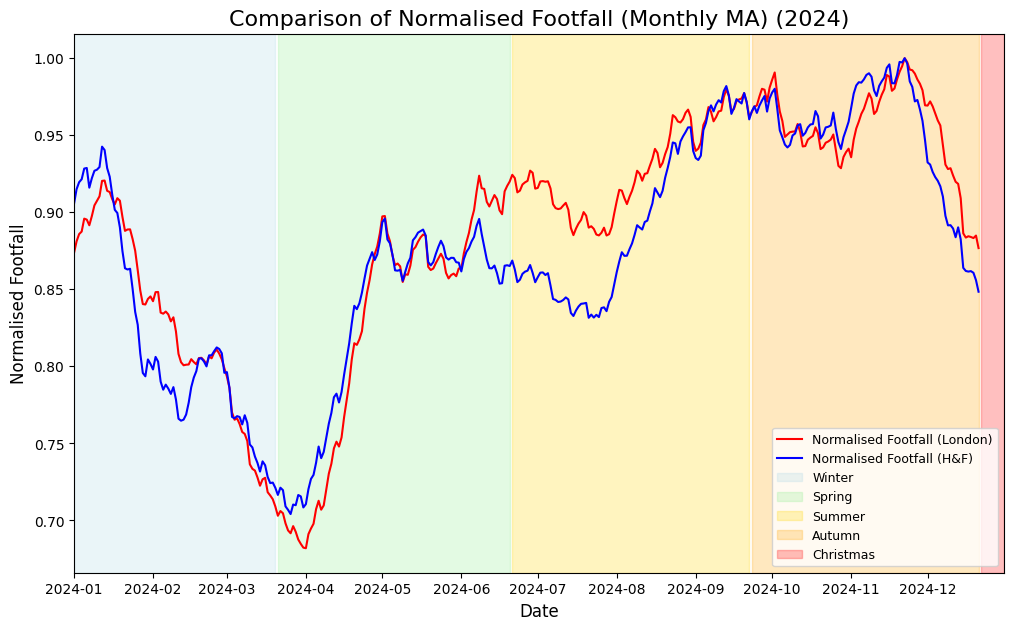

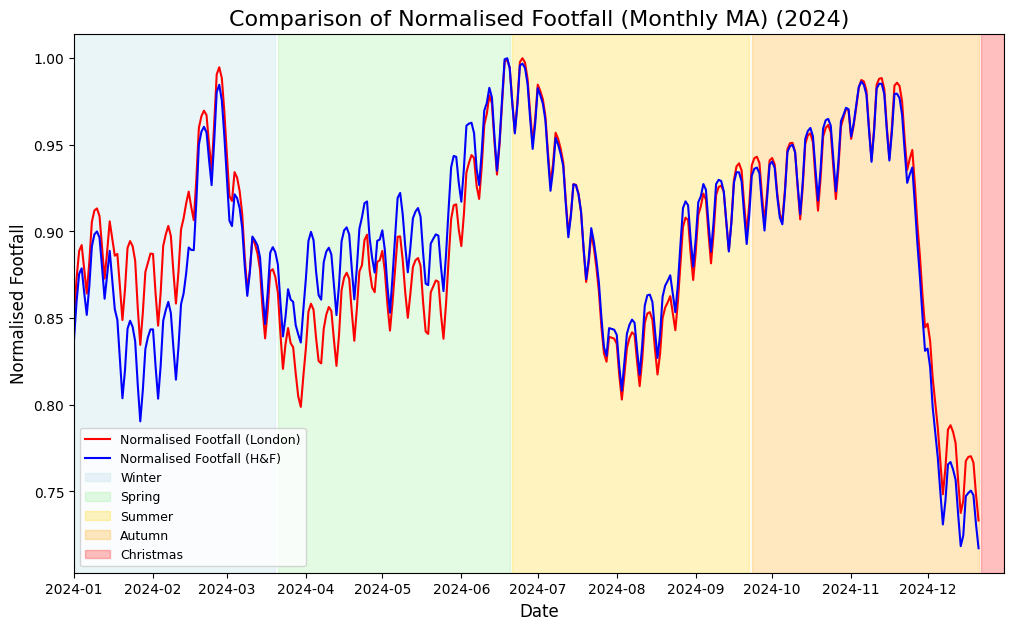

In [40]:
plot_footfall(agg_lon_footfall_data, df2=agg_lbhf_footfall_data, year=2024, category='normalized')
plot_footfall(res_lon_footfall_data, df2=res_lbhf_footfall_data, year=2024, category='normalized')
plot_footfall(no_res_lon_footfall_data, df2=no_res_lbhf_footfall_data, year=2024, category='normalized')
plot_footfall(vis_lon_footfall_data, df2=vis_lbhf_footfall_data, year=2024, category='normalized')
plot_footfall(work_lon_footfall_data, df2=work_lbhf_footfall_data, year=2024, category='normalized')

DataFrame: aggregated_data


,day_name,Nighttime_mean,Daytime_mean
day_order,,,
0,Monday,215529.283019,513647.207547
1,Tuesday,228828.792453,562502.584906
2,Wednesday,236481.942308,569587.519231
3,Thursday,247453.384615,581196.903846
4,Friday,258488.442308,506186.980769
5,Saturday,280208.980769,451722.826923
6,Sunday,204373.365385,367980.115385


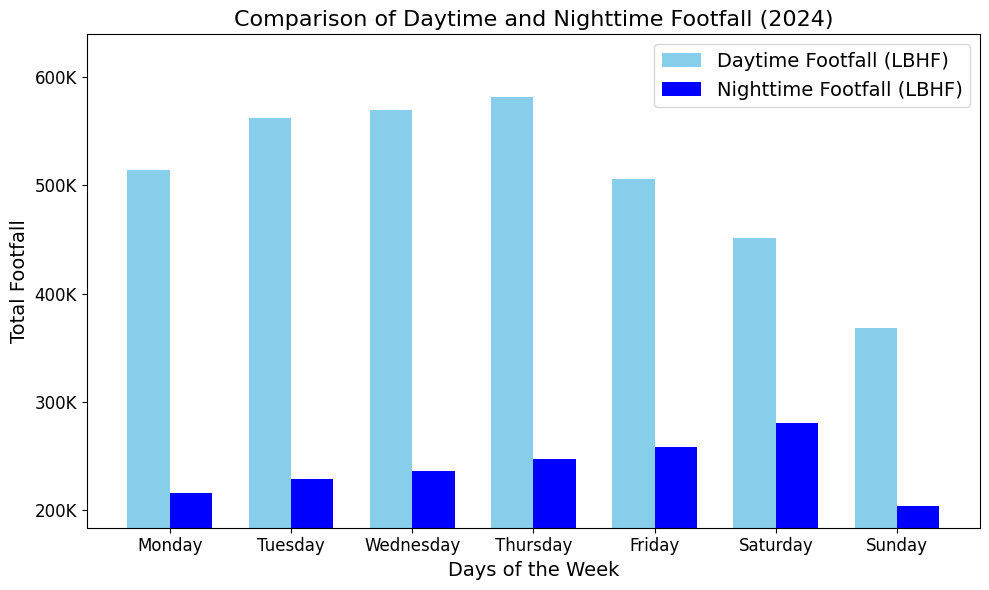

In [41]:
plot_daily_footfall(dn_lbhf_footfall_data, year=2024, day_night=True)

In [42]:
calulcaute_QoQ_values(agg_lbhf_footfall_data)
calulcaute_QoQ_values(agg_lon_footfall_data)

DataFrame: quarterly_df


,corrected_value_total,QoQ_change,YoY_change
count_date,,,
2022-06-30,1391054.55,NaN,NaN
2022-09-30,1513581.18,8.81,NaN
2022-12-31,1587138.12,4.86,NaN
2023-03-31,1698746.98,7.03,NaN
2023-06-30,1613787.07,-5.00,16.01
2023-09-30,1456290.61,-9.76,-3.79
2023-12-31,1716552.80,17.87,8.15
2024-03-31,1708876.37,-0.45,0.60
2024-06-30,1729020.89,1.18,7.14


DataFrame: quarterly_df


,corrected_value_total,QoQ_change,YoY_change
count_date,,,
2022-06-30,57044269.01,NaN,NaN
2022-09-30,61715690.01,8.19,NaN
2022-12-31,65092744.77,5.47,NaN
2023-03-31,68271960.38,4.88,NaN
2023-06-30,64272145.13,-5.86,12.67
2023-09-30,57877947.82,-9.95,-6.22
2023-12-31,71507561.90,23.55,9.85
2024-03-31,71652527.86,0.20,4.95
2024-06-30,71738124.13,0.12,11.62


,corrected_value_total,QoQ_change,YoY_change
count_date,,,
2022-06-30,57044269.01,NaN,NaN
2022-09-30,61715690.01,8.19,NaN
2022-12-31,65092744.77,5.47,NaN
2023-03-31,68271960.38,4.88,NaN
2023-06-30,64272145.13,-5.86,12.67
2023-09-30,57877947.82,-9.95,-6.22
2023-12-31,71507561.90,23.55,9.85
2024-03-31,71652527.86,0.20,4.95
2024-06-30,71738124.13,0.12,11.62
